In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import approx_fprime, minimize_scalar, curve_fit

# Cvičení 9: Optimalizace & Ortogonální polynomy

## Část A: Optimalizace & Nelineární nejmenší čtverce

---
- [poznámky z přednášky - optimalizace 1](https://www.karlin.mff.cuni.cz/~kucera/ZNM/3%20-%20Optimalizace.pdf)
- [poznámky z přednášky - optimalizace 2](https://www.karlin.mff.cuni.cz/~kucera/ZNM/4%20-%20Ortogonalni%20polynomy.pdf)
- další materiály:
  - volně dostupná kniha [Nocedal, Wright: Numerical Optimization](https://www.math.uci.edu/~qnie/Publications/NumericalOptimization.pdf).
  - volně dostupná kniha [Madsen, Nielsen, Tingleff: Methods for Non-Linear Least Squares Problems](https://www2.imm.dtu.dk/pubdb/edoc/imm3215.pdf).
  - skripta [Foundations of Applied Mathematics](https://foundations-of-applied-mathematics.github.io/) (Volume 2, Kapitoly 12, 13, 14 a 15)
  
- ***Primární úlohy*** : A2, A3

- ***Úlohy k bonusové části zkoušky*** : A1

- základní ***Learning outcomes*** (cviko, nikoliv přednáška)
  - Umím zařadit konkrétní optimalizační metody do jedné ze 3 základních kategorií (derivative-free, prvního stupně, druhého stupně).
  - Umím pojmenovat silné a slabé stránky 3 základních kategorií optimalizační metody (derivative-free, prvního stupně, druhého stupně).
---

### Intro

Dvě cvika zpátky jsme řešili lineární problém nejmenších čtverců, kde jsme hledali řešení

$$
\min\limits_{\mathbf{x} \in \mathbb{R}^n} \, \frac{1}{2} \left\| \mathbf{b} - A \mathbf{x} \right\|_2^2
\quad \left( \equiv \quad
\min\limits_{\mathbf{x} \in \mathbb{R}^n} \, \left\| \mathbf{b} - A \mathbf{x} \right\|_2 \right).
$$

Jak jsme naznačovali/odkazovali už tam, tak *lineární* problém nejmenších čtverců je pouze speciální případ obecného problému nejmenších čtverců, kde pro danou funkci $\mathbf{F}\, :\, \mathbb{R}^{n}\rightarrow \mathbb{R}^{m}$ chceme řešit

$$
\min\limits_{\mathbf{x} \in \mathbb{R}^n} \, \frac{1}{2} \left\| \mathbf{F}( \mathbf{x} )\right\|_2^2
\quad \left( \equiv \quad
\min\limits_{\mathbf{x} \in \mathbb{R}^n} \, \left\| \mathbf{F}( \mathbf{x} ) \right\|_2 \right).
$$

Mnoho, ne-li většina aplikací, ze kterých tyto problémy pramení souvisí s MLE principem;  více detailů a cool příklady lze najít v (českém) článku [200 let metody nejmenších čtverců](https://eudml.org/doc/196517) nebo třeba v knize [Hřebíček, Gander: Solving Problems in Scientific Computing using Maple and MATLAB](https://math.haifa.ac.il/ROVENSKI/rovenski/Proj.pdf).

Nicméně i toto je pouze relativně úzká podmnožina *optimalizačních problémů*, které se pro danou funkci $f\, : \, \mathbb{R}^{n} \rightarrow \mathbb{R}$ snaží najít

$$
\min\limits_{\mathbf{x} \, \in \,  \mathcal{C}} \, f( \mathbf{x} ),
$$

kde $\mathcal{C} \subset \mathbb{R}^{n}$ je daná množina, na které chceme minimalizovat $f$ ("$\mathcal{C}$" jako *constraint set*). My se níže podíváme pouze na případ $C=\mathbb{R}^{n}$, tj. žádná omezení si klást nebudeme. To je v mnoha případech nerealistické, ale postupy pro $\mathcal{C} \neq \mathbb{R}^{n}$ jdou nad rámec základního kurzu - více se můžete naucčit v předmětech [Numerická optimalizace 1](https://is.cuni.cz/studium/predmety/index.php?id=cb4f3efaaec13b50e61406ca19460e4d&tid=&do=predmet&kod=NMNV503) a [Numerická optimalizace 2](https://is.cuni.cz/studium/predmety/index.php?id=cb4f3efaaec13b50e61406ca19460e4d&tid=&do=predmet&kod=NMNV544&skr=2024&fak=11320).


Na přednášce jsme viděli celkem tři kategorie *iterativních* metod (jiné se prakticky využívají spíše ojediněle)
  - **derivative-free** - založeno pouze na vyhodnocování $f$,
    - [bisekce](https://en.wikipedia.org/wiki/Bisection_method), [metoda zlatého řezu](https://en.wikipedia.org/wiki/Golden-section_search), [**Nelder-Mead**](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)
  - **first order** - založeno na vyhodnocování $f$ a jejího gradientu $\nabla f$,
    - [metoda největšího spádu](https://en.wikipedia.org/wiki/Gradient_descent), [metoda sdružených gradientů](https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method), [metoda stochastických gradientů](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), [trust-region metody](https://en.wikipedia.org/wiki/Trust_region),
  - **second order** - založeno na vyhodnocování $f$, $\nabla f$ a jejího hessiánu $\nabla^2 f$ (matice druhých parciálních derivací),
    - [Newtonova metoda](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization), [kvazi-Newton metody](https://en.wikipedia.org/wiki/Quasi-Newton_method#Search_for_extrema:_optimization) (Broyden-Fletcher/BFGS), [trust-region metody](https://en.wikipedia.org/wiki/Trust_region)

Na přednášce jsme viděli 3 konkrétní *iterativní* metody, které lze přirozeně použít pro obecnou minimalizaci v $\mathbb{R}^{n}$ - otázka je tedy vždy jak na základě aproximace minima $\mathbf{x}_k\in \mathbb{R}^{n}$ navrhnout lepší aproximace $\mathbf{x}_{k+1}\in \mathbb{R}^{n}$.

[**Metoda největšího spádu**](https://en.wikipedia.org/wiki/Gradient_descent)
> $$ \mathbf{x}_{k+1} = \mathbf{x}_{k} - \alpha_k \nabla f(\mathbf{x}_{k}), $$
>
> kde $\alpha_k\in \mathbb{R}$ volíme pomocí tzv. line-search, tj. (přibližné) 1D minimalizace funkce $\ell(\alpha) := f \left( \mathbf{x}_{k} - \alpha \nabla f(\mathbf{x}_{k}) \right)$

[**Newtonova metoda**](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)
> $$ \mathbf{x}_{k+1} = \mathbf{x}_{k} - \gamma_k \mathbf{v}_k, $$
>
> kde vektor $\mathbf{v}_k$ získáme jako řešení soustavy lineárních algebraických rovnic $[ \, \nabla^2 f(\mathbf{x}_{k}) \, ] \, \mathbf{v}_k = \nabla f(\mathbf{x}_{k})$.
> - *Newtonova metoda* odpovídá $\gamma_k=1$,
> - *damped/relaxed Newtonova metoda* (česky bychom řekli "utlumená") odpovídá volbě $\gamma_k\in (0,1)$ tak, aby nedocházelo k "přestřelení", (viz [Armijo rule](https://en.wikipedia.org/wiki/Backtracking_line_search#Algorithm) nebo [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions)),
> - *line-search Newtonova metoda* odpovídá volbě $\gamma_k$ pomocí line-search, tj. (přibližné) 1D minimalizace funkce $\ell(\alpha) := f \left( \mathbf{x}_{k} - \alpha \mathbf{v}_{k} \right)$.

[**Levenberg-Marquardt**](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm)
> $$ \mathbf{x}_{k+1} = \mathbf{x}_{k} - \gamma_k \mathbf{v}_k, $$
>
> kde vektor $\mathbf{v}_k$ získáme jako řešení soustavy lineárních algebraických rovnic $[ \, \beta_k I + \nabla^2 f(\mathbf{x}_{k}) \, ] \, \mathbf{v}_k = \nabla f(\mathbf{x}_{k})$.
> - $\beta_k \geq 0$ volíme na základě dalších heuristik, např. porovnáváme míru snížení $f$ v porovnáním s čístě lineárníém modelem (odpovídá metodě největšího spádu), viz []().
> - *line-search Levenberg-Marquardt* odpovídá volbě $\gamma_k$ pomocí line-search, tj. (přibližné) 1D minimalizace funkce $\ell(\alpha) := f \left( \mathbf{x}_{k} - \alpha \nabla \mathbf{v}_{k} \right)$,
> - stejně jako pro Newtonovu metodu se někdy volí $\gamma_k=1$ (nižší výpočetní náklady) nebo $\gamma_k\in (0,1)$ (viz [Armijo rule](https://en.wikipedia.org/wiki/Backtracking_line_search#Algorithm) nebo [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions)).



teoreticke cviceni jsou na formulaci Levenberg-MArquardt pro specialni pripad funkce co chci minimalizovat je norma jine funkce nadruhou - nelinearni nejmensi ctverce

prakticke priklady jsou na implementaci Newton, Gauss-Newton a pak LevenbergMarqquardt



### Úloha A1 - numerická aproximace derivace

Když jsme implementovali Newtonovu metodu pro řešení soustav nelineárních algebraických rovnic, tak jsme předpokládali, že máme k dispozici nejen funkci `f`, ale i funkci `df`, která pro daný bod $\mathbf{x} \in \mathbb{R}^{n}$ vracela matici parciálních derivací (jakobián) $J_{\mathbf{x}} \in \mathbb{R}^{n\times n}$.

Z praktického hledsika je toto v podstatě luxus a často si takový předpoklad dovolit nemůžeme a musíme tedy být schopni (parciální) derivace funkcí aproximovat numericky - na toto téma narazíme i na konci semestru při aproximaci řešení obyčejných diferenciálních rovnic, ale tady si ukážeme pouze ten nejjednodušší způsob - tzv. [*metodu konečných diferencí*](https://en.wikipedia.org/wiki/Finite_difference_method).

Její idea je založena na Taylorově rozvoji pro dostatečně hladké funkce, tedy na rovnostech

\begin{eqnarray}
f(x+h) &=& f(x) + f^{(1)}(x) \cdot h  + \frac{f^{(2)}(x)}{2} \cdot h^2 +  \dotsc + \frac{f^{(n)}(x)}{n!} \cdot h^n + \frac{f^{(n+1)}(\xi_n)}{(n+1)!} \cdot h^{n+1}, \qquad (\Delta) \\
f(x-h)  &=& f(x) - f^{(1)}(x) \cdot h  + \frac{f^{(2)}(x)}{2} \cdot h^2 +  \dotsc + \frac{f^{(n)}(x)}{n!} \cdot (-h)^n + \frac{f^{(n+1)}(\zeta_n)}{(n+1)!} \cdot (-h)^{n+1}, \qquad (\square)
\end{eqnarray}

kde jsme použili Lagrangeův tvar zbytku.

---
**Tužka a papír** :

- Vyjádřete $f^{(1)}(x)$ z Taylora rozvoje $(\Delta)$ a aproximujte $f^{(1)}(x)$ pouze za použití funkčních hodnot $f(\cdot)$.
  <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>
  
  Jinými slovy, zanedbáme všechny členy obsahující $f^{(2)}(x), f^{(3)}(x)$ atd., čímž záskáme $f^{(1)}(x) \approx$ ...pouze výrazy obsahující $f(x),f(x+h)$.
  
  </details>
- Jak velké nepřesnosti se dopouštíme v závislosti na $h$? (ve smyslu $\mathcal{O}(h^{k})_{h\rightarrow 0}$ notace)?

- Šikovnou kombinací rozvojů $(\Delta)$ a $(\square)$ odvoďte aproximaci
$$ f^{(2)}(x) = \frac{ f(x+h) - 2f(x) + f(x-h) }{h^2} + \mathcal{O}(h^2)_{h\rightarrow 0}.$$

- Vysvětlete, jak lze použít aproximace výše pro numerickou aproximaci gradientu $\nabla f(\mathbf{x})$ a hessiánu $[\, \nabla^2 f(\mathbf{x}) \,]$.
---

### Úloha A2 - implementace

---
**Kódění** : Naimplementujte "jeden krok" našich tří minimalizačních metod výše ve verzi *line-search*.
  - bude se nám hodit alternativní způsob definování `python` *funkcí* pomocí [lambda keyword](https://www.w3schools.com/python/python_lambda.asp)
  <details>
  <summary>Chci <font color="red"><b>detaily</b></font></summary>
  
  Příklad 1 - definujeme si funkci $f(x) := x^2 - 17$.
  ```
  f = lambda x : x**2 - 17
  print( f(5) ) ### vytiskne 5**2-17, tj. 8
  ```
  
  Příklad 2 - definujeme si funkci $g(\alpha) := f(\alpha + 3)$.
  ```
  g = lambda x : f(x+3)
  print( g(5) ) ### vytiskne (5+3)**2-17, tj. 47
  ```
  
  Příklad 3 - definujeme si funkci $h(\beta) := g(\beta - 3)$.
  ```
  h = lambda x : g(x-3)
  print( h(5) ) ### vytiskne (5+3-3)**2-17, tj. 8
  ```
  
  </details>

  - pro 1D minimalizaci libovolné funkce použijte [`minimize_scalar(f_LineSearch, tol=PresnostLineSearch)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) z knihovny `scipy.optimize`, která nalezne minimum s ppřesností/tolerancí `PresnostLineSearch`. Pozor na to, že output této funkce je sám o sobě python objekt - hodnotu inputu, který danou funkci minimalizuje získáme například následujícím způsobem.
  ```
  f = lambda x : x**2 - 1 # funkce co chci minimalizovat
  VysledekMinimalizace = minimize_scalar(f, tol=Presnost) # pustim minimalizaci, output je objekt
  InputKteryMinimalizuje = VysledekMinimalizace.x # vytahnu si z toho objektu ten input co minimalizuje "f"
  ####################
  print(VysledekMinimalizace.x) # vytiskne minimalizujici input, tj. x=0
  print(VysledekMinimalizace) # vytiskne info o minimalizaci, nejen x=0, ale taky tu minimalni hodnotu,
                                # pocet vyhodnoceni funkce "f", atd.
  ```

  <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>
  
  Skalární funkci pro line search si můžeme zadefinovat uvnitř každé z našich implementací pomocí existující funkce `f`, keyword `lambda` a matematických formulací výše.
  
  </details>

  - pro numerickou aproximaci gradientu a hessiánu použijeme právě metodu z Úlohy A1. Ta je implementovaná v knihovně `scipy.optimize` jako funkce [`approx_fprime()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html#scipy.optimize.approx_fprime) pro aproximaci první derivace nebo gradientu v případě funkcí více proměnných. Aproximaci hessiánu lze napsat jako "dvojité použití `approx_fprime()` - pro jednoduchost máme níže předpřipravenou funkci `approx_f_grad_Hess(xk, f, PresnostAproximace)`, která nám vrátí aproximace $\nabla f(x_k), [\, \nabla^2 f(x_k) \,]$ s přesností aproximace `PresnostAproximace` pro každý z outputů.
  
  - Jaký vztah je rozumné požadovat mezi požadovanou přesností uvnitř line-search minimalizace (`PresnostLineSearch`) a přesností aproximace gradientu a hessiánu (`PresnostAproximace`) - $\gg, \, \ll,$ nebo $\approx$ a proč?




---

In [ ]:
def approx_f_grad_Hess(xk,f,PresnostAproximace):
  '''Aproximujeme prvni a druhou derivaci funkce "f" v bode "xk" (nebo jakobian a hessian pro funkce vice promennych) s chybou odpovidajici radove "PresnostAproximace".'''
  f_grad = lambda x : approx_fprime(x,f, epsilon=np.sqrt(PresnostAproximace))
  hess_f = approx_fprime(xk,f_grad, epsilon=np.sqrt(PresnostAproximace))
  grad_f = approx_fprime(xk,f, epsilon=PresnostAproximace)
  if np.isscalar(xk):
      hess_f = np.array([[hess_f]])
  return grad_f, hess_f


def JedenKrok_SteepestDescent(f,xk, Presnost=1e-4):
  '''
  Pro dany pocatecni bod "xk" a funkci "f" vypocte jeden krok metody nejvetsiho spadu (line-search i aproximace gradientu "f" jsou radove na urovni "Presnost").

  Input
  -------
  f :   python funkce (callable). Funkce "f : R^n -> R", kterou chceme minimalizovat
        syntax "f( np.array([x1,...,xn]) )". Tj. nevolame funkci jako funkci "n" promennych, ale jako funkci s jednim inputem - vektorem z R^n
  xk :  np.array dimenze "n" s prvky np.float64. Pocatecni aproximace minima
  Presnost : np.float64. Rad chyby, kterou tolerujeme rpi line-search a pri numericke aproximaci gradientu "f"

  Output
  -------
  xkp1 :  np.array dimenze "n" s prvky np.float64. Aproximace minima po jednom kroku metody nejvetsiho spadu.
  '''
  return xkp1

#################################################################### Testovani
def test_JedenKrok_SteepestDescent():
  def f1(x):
    return np.exp(x**2)
  def f2(x):
    return x[0]**2 + 2*x[1]**2

  x0 = 1; tol = 1e-8
  x1 = JedenKrok_SteepestDescent(f1,x0,tol)
  assert np.size(x1) == 1, "Pro f: R -> R funkce by mel output byt skalar, ale JedenKrok_SteepestDescent vraci output dimenze {}.".format(x1.shape)
  assert np.abs(x1) <= 10*tol, "Pro f: R -> R funkce by mela metoda nejvyssiho spadu najit presne minimum (s presnosti 'Presnost'). Ale pro funkci 'f(x) = e^(x^2)' a x0 = {} mame presne reseni '0', ale funkce vraci {}.".format(x0,x1)

  x0 = np.ones(2); tol = 1e-8
  x1 = JedenKrok_SteepestDescent(f2,x0,tol)
  assert len(x1) == 2, "Pro f: R^2 -> R funkce by mel output byt vektor delky 2, ale funkce vraci output delky {}.".format(x1.shape)
  assert np.linalg.norm(np.array([4/9,-1/9]) - x1) <= 10*tol, "Pro f : [x,y] -> x^2 + 2y^2 a xk=[1,1] by mela metoda nejvyssiho spadu najit gradient [2,4] (s presnosti 'Presnost') a vyresit naslednou minimalizaci s alpha_1=5/18 (s presnosti 'Presnost') a tedy vratit xk+1=[1,1]-5/18[2,4]. Ale output je {}.".format(x1)
  return '"JedenKrok_SteepestDescent()" je OK'
test_JedenKrok_SteepestDescent()
#################################################################### Testovani

'"JedenKrok_SteepestDescent()" je OK'

In [ ]:
def approx_f_grad_Hess(xk,f,PresnostAproximace):
  '''Aproximujeme prvni a druhou derivaci funkce "f" v bode "xk" (nebo jakobian a hessian pro funkce vice promennych) s chybou odpovidajici radove "PresnostAproximace".'''
  f_grad = lambda x : approx_fprime(x,f, epsilon=np.sqrt(PresnostAproximace))
  hess_f = approx_fprime(xk,f_grad, epsilon=np.sqrt(PresnostAproximace))
  grad_f = approx_fprime(xk,f, epsilon=PresnostAproximace)
  if np.isscalar(xk):
      hess_f = np.array([[hess_f]])
  return grad_f, hess_f


def JedenKrok_Newton(f,xk, Presnost=1e-4):
  '''
  Pro dany pocatecni bod "xk" a funkci "f" vypocte jeden krok Newtonovy metody s line-search (line-search i aproximace gradientu a hessianu "f" jsou radove na urovni "Presnost").

  Input
  -------
  f :   python funkce (callable). Funkce "f : R^n -> R", kterou chceme minimalizovat
        syntax "f( np.array([x1,...,xn]) )". Tj. nevolame funkci jako funkci "n" promennych, ale jako funkci s jednim inputem - vektorem z R^n
  xk :  np.array dimenze "n" s prvky np.float64. Pocatecni aproximace minima
  Presnost : np.float64. Rad chyby, kterou tolerujeme rpi line-search a pri numericke aproximaci gradientu a hessianu "f"

  Output
  -------
  xkp1 :  np.array dimenze "n" s prvky np.float64. Aproximace minima po jednom kroku Newtonovy metody s line-search.
  '''
  return xkp1

#################################################################### Testovani
def test_JedenKrok_Newton():
  def f1(x):
    return np.exp(x**2)
  def f2(x):
    return x[0]**2 + 2*x[1]**2

  x0 = 1; tol = 1e-8
  x1 = JedenKrok_Newton(f1,x0,tol)
  assert np.size(x1) == 1, "Pro f: R -> R funkce by mel output byt skalar, ale JedenKrok_Newton() vraci output dimenze {}.".format(x1.shape)
  assert np.abs(x1) <= 10*tol, "Pro f: R -> R funkce by mela Newtonova metoda najit presne minimum (s presnosti 'Presnost'). Ale pro funkci 'f(x) = e^(x^2)' a x0 = {} mame presne reseni '0', ale funkce vraci {}.".format(x0,x1)

  x0 = np.ones(2); tol = 1e-8
  x1 = JedenKrok_Newton(f2,x0,tol)
  assert len(x1) == 2, "Pro f: R^2 -> R funkce by mel output byt vektor delky 2, ale funkce vraci output delky {}.".format(x1.shape)
  assert np.linalg.norm(np.array([0,0]) - x1) <= 10*tol, "Pro f : [x,y] -> x^2 + 2y^2 a xk=[1,1] by mela Newtonova metoda najit presne reseni v jedne iteraci, protoze se jedna o kvadratickou funkci (s presnosti 'Presnost') a tedy vratit xk+1=[0,0]. Ale output je {}.".format(x1)
  return '"JedenKrok_Newton()" je OK'
test_JedenKrok_Newton()
#################################################################### Testovani

'"JedenKrok_Newton()" je OK'

In [ ]:
def approx_f_grad_Hess(xk,f,PresnostAproximace):
  '''Aproximujeme prvni a druhou derivaci funkce "f" v bode "xk" (nebo jakobian a hessian pro funkce vice promennych) s chybou odpovidajici radove "PresnostAproximace".'''
  f_grad = lambda x : approx_fprime(x,f, epsilon=np.sqrt(PresnostAproximace))
  hess_f = approx_fprime(xk,f_grad, epsilon=np.sqrt(PresnostAproximace))
  grad_f = approx_fprime(xk,f, epsilon=PresnostAproximace)
  if np.isscalar(xk):
      hess_f = np.array([[hess_f]])
  return grad_f, hess_f


def JedenKrok_LevenbergMarquardt(f,xk,beta, Presnost=1e-4):
  '''
  Pro dany pocatecni bod "xk" a funkci "f" vypocte jeden krok metody Levenberg-Marquardt (line-search i aproximace gradientu "f" jsou radove na urovni "Presnost").

  Input
  -------
  f :   python funkce (callable). Funkce "f : R^n -> R", kterou chceme minimalizovat
        syntax "f( np.array([x1,...,xn]) )". Tj. nevolame funkci jako funkci "n" promennych, ale jako funkci s jednim inputem - vektorem z R^n
  xk :  np.array dimenze "n" s prvky np.float64. Pocatecni aproximace minima
  beta : np.float64. koeficient metody Levenberg-Marquardt.
  Presnost : np.float64. Rad chyby, kterou tolerujeme rpi line-search a pri numericke aproximaci gradientu "f"

  Output
  -------
  xkp1 :  np.array dimenze "n" s prvky np.float64. Aproximace minima po jednom kroku metody Levenberg-Marquardt s line-search.
  '''
  return xkp1

#################################################################### Testovani
def test_JedenKrok_LevenbergMarquardt():
  def f1(x):
    return np.exp(x**2)
  def f2(x):
    return x[0]**2 + 2*x[1]**2

  x0 = 1; tol = 1e-8; beta = 1
  x1 = JedenKrok_LevenbergMarquardt(f1,x0,beta, tol)
  assert np.size(x1) == 1, "Pro f: R -> R funkce by mel output byt skalar, ale JedenKrok_LevenbergMarquardt() vraci output dimenze {}.".format(x1.shape)
  assert np.abs(x1) <= 10*tol, "Pro f: R -> R funkce by mela Levenberg-Marquardt metoda najit presne minimum (s presnosti 'Presnost'). Ale pro funkci 'f(x) = e^(x^2)' a xk = {} mame presne reseni '0', ale funkce vraci {}.".format(x0,x1)

  x0 = np.ones(2); tol = 1e-8
  x1_b0 = JedenKrok_LevenbergMarquardt(f2,x0,0,tol); x1_N = JedenKrok_Newton(f2,x0,tol)
  x1_binf = JedenKrok_LevenbergMarquardt(f2,x0,1e+8,tol); x1_SD = JedenKrok_SteepestDescent(f2,x0,tol)
  x1_b2 = JedenKrok_LevenbergMarquardt(f2,x0,2,tol)
  assert len(x1_b0) == 2, "Pro f: R^2 -> R funkce by mel output byt vektor delky 2, ale JedenKrok_LevenbergMarquardt() vraci output delky {}.".format(x1_b0.shape)
  assert np.linalg.norm(x1_N - x1_b0) <= 10*tol, "Pro f : [x,y] -> x^2 + 2y^2, xk=[1,1] & beta=0 by mela Levenberg-Marquardt metoda odpovidat Newtonove metode a tedy vratit xk+1=[0,0] (s presnosti 'Presnost'). Ale output je {}.".format(x1_b0)
  assert np.linalg.norm(x1_SD - x1_binf) <= 10*tol, "Pro f : [x,y] -> x^2 + 2y^2, xk=[1,1] & beta=1e+10 by mela Levenberg-Marquardt metoda odpovidat metode nejvyssiho spadu a tedy vratit xk+1=[4/9,-1/9,0] (s presnosti max('Presnost',1e-10)). Ale output je {}.".format(x1_binf)
  assert np.linalg.norm(np.array([1-33/41,1-44/41]) - x1_b2) <= 10*tol, "Pro f : [x,y] -> x^2 + 2y^2 a xk=[1,1] & beta=1 by mela Levenberg-Marquardt metoda najit smer vk=[1/2,2/3] (s presnosti 'Presnost') a vyresit naslednou minimalizaci s alpha_1=66/41 (s presnosti 'Presnost') a tedy vratit xk+1=[1,1]-5/18[2,4]. Ale output je {}.".format(x1_b2)
  return '"JedenKrok_LevenbergMarquardt()" je OK'
test_JedenKrok_LevenbergMarquardt()
#################################################################### Testovani

'"JedenKrok_LevenbergMarquardt()" je OK'

### Úloha A3 - Rosenbrock

Otestujeme naše nakóděné metody na klasickém optimalizačním problému - hledání minima tzv. [Rosenbrock funkce](https://en.wikipedia.org/wiki/Rosenbrock_function) $f(\mathbf{x})\, : \, \mathbf{x}\equiv [x_1,x_2] \, \mapsto \, (1-x_1)^2 + 100(x_2-x_1^2)^2$ v $\mathbb{R}^{2}$.

---
**Kódění** : Zreplikujte experiment níže pro naše tři metody.
- Počáteční parametry volíme jako `x0 = [-1,3/4]` a `Presnost=1e-4` (ale můžete samozřejmě experimentovat s různými volbami).
- Zavedeme nový parametr `PocetKroku`, který nám určí kolik kroků u každé z metod uděláme. (Samozřejmě v praxi bychom nedělali fixní počet kroků, ale měli nějaké zastavovací kritérium, stejně jako u ostatních ite
čních metod, co jsme viděli.)
- Všechny aproximace $\mathbf{x}_k$ si budeme ukládat do polí `xk_SD`, `xk_NM` a `xk_LM`  (jako vždy začneme předpokládáme, že v $\mathbf{x}_k$ je uloženov poli `xk_SD[k,:]`, včetně $\mathbf{x}_0$).

- Pro metodu `JedenKrok_LevenbergMarquardt()` je zapotřebí vhodně volit parametr $\beta_k>0$.
  - Jaké metodě odpovídá "LM" pro $\beta_k = 0$ a jaké metodě odpovídá pro "$\beta_k=+\infty$"?
  - Která z těchto metod je efektivnější, pokud jsme už blízko minima a která je robustnější, pokud jsme ještě daleko od minima?

  - Pro naší testovací Rosenbrock funkci $f$ platí, že je vždy nezáporná a má globální minimum s hodnotou $0$ (podobnou informaci často máme i pro problémy z nejmenších nelineárních čtverců, viz výše). Takže z praktického hlediska lze "měřit kvalitu aproximace $\mathbf{x}_k$ skrze $f(\mathbf{x}_k)$" - pokud je $f(\mathbf{x}_k)$ "velké", pak "pravděpodobně nejsme blízko minima" a naopak.

  - Pro grafy níže jsme použili následující
  $$
  \beta_k = c\cdot f(\mathbf{x}_k) \qquad \mathrm{kde} \qquad
  c = \left\{
    \begin{aligned}
    10, &\qquad \mathrm{pokud} \; f(\mathbf{x}_k) \in (10,+\infty) \\
    1, &\qquad \mathrm{pokud} \; f(\mathbf{x}_k) \in (1,10)  \\
    0.01, &\qquad \mathrm{pokud} \; f(\mathbf{x}_k)  \in (0,1)
    \end{aligned}
    \right.
  $$
  na základě [Scientific Computing - An introduction using Maple and MATLAB, Sekce 6.8.4, nad rovnicí (6.100), str. 364](https://link.springer.com/book/10.1007/978-3-319-04325-8). Další, a sofistikovanější volby (ale se stejnou myšlenkou na pozadí) můžeme najít např. v [Methods for Non-Linear Least Squares Problems, Sekce 3.2, str. 25-26](https://www2.imm.dtu.dk/pubdb/edoc/imm3215.pdf). Vysvětlete smysl volby výše v kontextu našich předchozích pozorování.
---

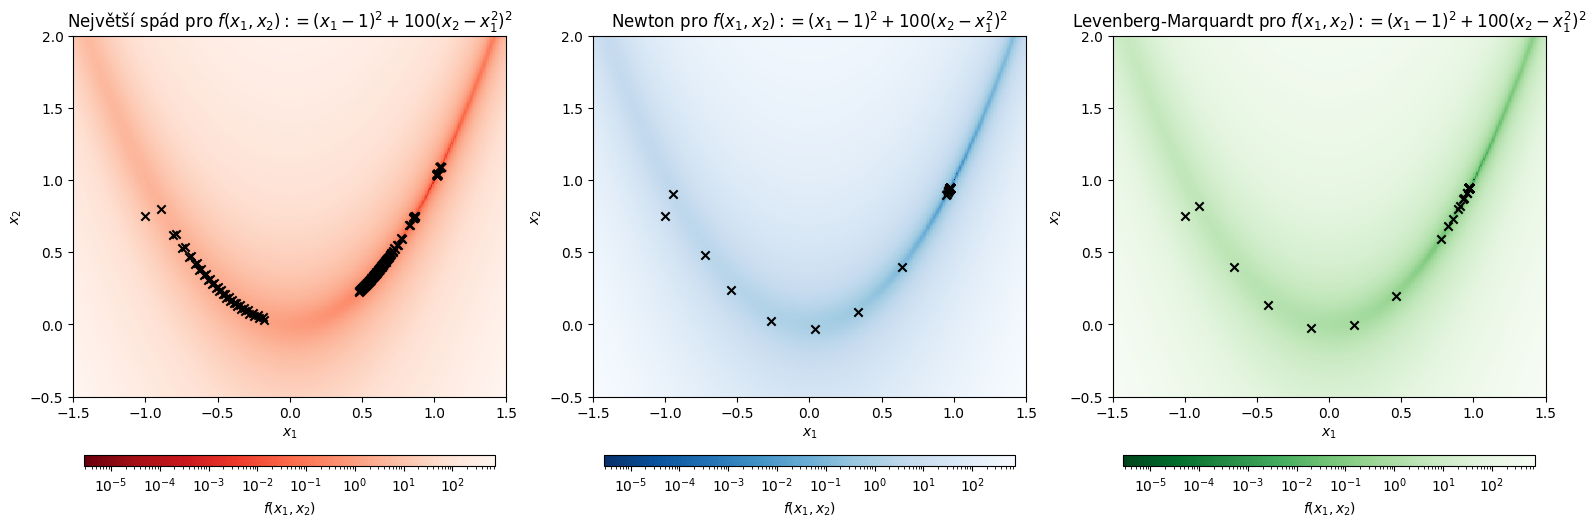

In [ ]:
def Rosenbrock_Plot(x,y,a=1,b=100):
  return (a-x)**2 + b*(y-x**2)**2
def Rosenbrock(x,a=1,b=100):
  return (a-x[0])**2 + b*(x[1]-x[0]**2)**2


x0 = np.array([-1,3/4]); Presnost = 1e-4; PocetKroku = 200

# inicialiazace
xk_SD = np.zeros((PocetKroku+1,2)); xk_NM = np.zeros_like(xk_SD); xk_LM = np.zeros_like(xk_SD)
xk_SD[0,:] = x0; xk_NM[0,:] = x0; xk_LM[0,:] = x0;

# vypocet
for ind in range(0,PocetKroku):

  xk_SD[ind+1,:] =
  xk_NM[ind+1,:] =
  xk_LM[ind+1,:] =



########################################################## Vykreslovani - neni treba menit
import matplotlib.colors as colors
plt.figure(figsize=(19,9))

PlotBox = np.array([[-1.5,1.5],[-0.5,2]]); nmbpnts = 300;
x,y = np.mgrid[PlotBox[0,0]:PlotBox[0,1]:complex(0,nmbpnts), PlotBox[1,0]:PlotBox[1,1]:complex(0,nmbpnts)]
fvals = Rosenbrock_Plot(x,y); fvals = fvals[:-1, :-1]

ax = plt.subplot(1,3,1)
cntr = ax.pcolorfast(x,y,fvals, cmap="Reds_r", norm=colors.LogNorm(vmin=fvals.min(), vmax=fvals.max()), shading='auto'); plt.colorbar(cntr, ax=ax, location = 'bottom', label="$f(x_1,x_2)$", shrink=.95, aspect=40, pad=0.085)
for ind_k in range(0,PocetKroku+1):
  plt.scatter([xk_SD[ind_k,0]], [xk_SD[ind_k,1]], color="k", marker="x", label='SD')
ax.set_aspect('equal', 'box'); plt.xlim(PlotBox[0,0],PlotBox[0,1]); plt.ylim(PlotBox[1,0],PlotBox[1,1]);
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.set_title("Největší spád pro $f(x_1,x_2):= (x_1-1)^2 + 100(x_2-x_1^2)^2$");

ax = plt.subplot(1,3,2)
cntr = ax.pcolorfast(x,y,fvals, cmap="Blues_r", norm=colors.LogNorm(vmin=fvals.min(), vmax=fvals.max()), shading='auto'); plt.colorbar(cntr, ax=ax, location = 'bottom', label="$f(x_1,x_2)$", shrink=.95, aspect=40, pad=0.085)
for ind_k in range(0,PocetKroku+1):
  plt.scatter([xk_NM[ind_k,0]], [xk_NM[ind_k,1]], color="k", marker="x", label='SD')
ax.set_aspect('equal', 'box'); plt.xlim(PlotBox[0,0],PlotBox[0,1]); plt.ylim(PlotBox[1,0],PlotBox[1,1]);
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.set_title("Newton pro $f(x_1,x_2):= (x_1-1)^2 + 100(x_2-x_1^2)^2$");

ax = plt.subplot(1,3,3)
cntr = ax.pcolorfast(x,y,fvals, cmap="Greens_r", norm=colors.LogNorm(vmin=fvals.min(), vmax=fvals.max()), shading='auto'); plt.colorbar(cntr, ax=ax, location = 'bottom', label="$f(x_1,x_2)$", shrink=.95, aspect=40, pad=0.085)
for ind_k in range(0,PocetKroku+1):
  plt.scatter([xk_LM[ind_k,0]], [xk_LM[ind_k,1]], color="k", marker="x", label='SD')
ax.set_aspect('equal', 'box'); plt.xlim(PlotBox[0,0],PlotBox[0,1]); plt.ylim(PlotBox[1,0],PlotBox[1,1]);
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.set_title("Levenberg-Marquardt pro $f(x_1,x_2):= (x_1-1)^2 + 100(x_2-x_1^2)^2$");
plt.show()
########################################################## Vykreslovani - neni treba menit

### ZÚ - ledopád

Zkusíme si zopakovat výpočty, ve kterých se v praxi vyzužívá minimalizace, konkrétně nelineární nejmenší čtverce, tj úloha typu

$$
\min\limits_{\mathbf{x} \in \mathbb{R}^n} \, \frac{1}{2} \left\| \mathbf{F}( \mathbf{x} )\right\|_2^2. \qquad (\star)
$$

Následující obrátek a text je výňatek z článku [200 let metody nejmenších čtverců](https://eudml.org/doc/196517).





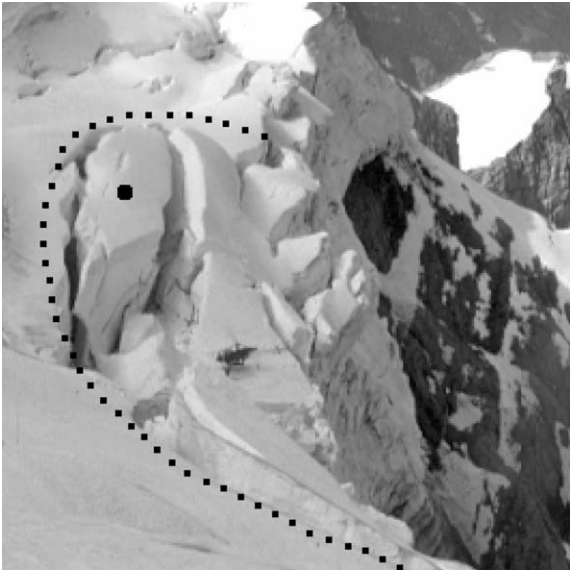

>V roce 1999 se začal vysoko v horách nad Grindelwaldem ve Švýcarsku pohybovat
zavěšený ledovec a ohrožoval oblast pod sebou obrovským vodopádem z ledu. Aby se
zabránilo vážné nehodě, bylo nutné přesně předpovědět, kdy se ledovec utrhne. Vědci z ETH v Zürichu (M. Funk) tedy usadili do masy ledu měřicí tyč (viz obrázek) a pozorně sledovali měnící se umístění tyče. Změřené údaje jsou

| Čas měření $t$ (dny) | Pohyb tyče $s(t)$ (metry) |
|:--------:| -------- |
| $t_0=0$ | $s_0 = 0$ |
| $t_1=2$ | $s_1 = 0.529$ |
| $t_2=7$ | $s_2 = 1.936$ |
| $t_3=12$ | $s_3 = 3.598$ |
| $t_4=13$ | $s_4 = 3.977$ |
| $t_5=15$ | $s_5 = 4.802$ |
| $t_6=16$ | $s_6 = 5.219$ |
| $t_7=17$ | $s_7 = 5.667$ |
| $t_8=19$ | $s_8 = 6.669$ |
| $t_9=20$ | $s_9 = 7.208$ |
| $t_{10}=22$ | $s_{10} = 8.464$ |

>Čas t = 0 odpovídá 18. červenci 1999, 7. hodině ráno. Dřívější zkušenosti s ledovcovými vodopády (zejména s ledopádem na Weisshornu)
ukázaly, že zvyšující se rychlost podobných ledových mas vyhovuje vzorci
>
>$$ v(t) = v_0 + \frac{a_0}{(t_{\infty}-t)^{n}}, $$
>
>nebo-li (po integraci)
>
>$$ s(t) = s_0 + v_0\cdot t + a_0 \cdot \frac{ (t_{\infty}-t)^{1-n} - t_{\infty}^{1-n} }{n-1}, $$
>
> kde $t_{\infty}>0$ odpovídá času utržení ledovce. Naším cílem je na základě 11 dostupných měření určit ***parametry modelu*** $s_0,v_0,a_0,t_{\infty}$ a $n$ tak, aby odpovídali meřením a tudíž předpovědět čas utržení ledovce. Z předchozích modelů víme, že $n\approx \tfrac{1}{2}$.

---
**Tužka a papír** : Rozepište formualci výše jako problém $(\star)$ pro konkrétní $\mathbf{F}$ a interpretujte význam $\mathbf{x}$.

**Kódění** : Nastudujte si a použijte funkci [`scipy.optimize.curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) pro výpočet našich neznámých parametrů.
  - My si vystačíme s "unconstrained optimization", ale je zapotřebí použít rozumný počáteční odhad - využijte, že máme pro některé neznámé parametry odhady (např. $n\approx 0.5$ nebo $t_{\infty} > 22$) a naopak volíme odhad $0$ pro hodnoty u kterých nemáme žádný odhad.
  - Zřejmě bude nutné implementovat funkci `PohybLedovce()`, která odpovídá funkci $s(t)$ výše.
  - Jakou minimalizační metodu tato pythoin implementace používá?
  - Pro konvergenci algoritmu (aspoň v mém set-upu) je zapotřebí zvýšit počet iterací - mně stačilo `maxfev = 10000`.

- Vykreslete data $(t_i,s_i)_{i=0,\dotsc ,10}$ spolu s predikcemi modelu `t_pred, s_pred`, kde `s_pred = PohybLedovce(t_pred, ... optimalni parametry ...)` a `t_pred` jsou body nagenerované na intervalu $(0,t_{\infty})$, např. pomocí `t_pred = np.linspace(0,t_infty,100)`.

- Ledovec se utrhl 14. srpna ve dvě hodiny ráno. Jak realita koresponduje s vaší předpovědí?
---

/tmp/ipython-input-3974183271.py:2: RuntimeWarning: invalid value encountered in power
  return s0 + t*v0 + a0 * ((t_infty-t)**(1-n) - t_infty**(1-n))/(n-1)


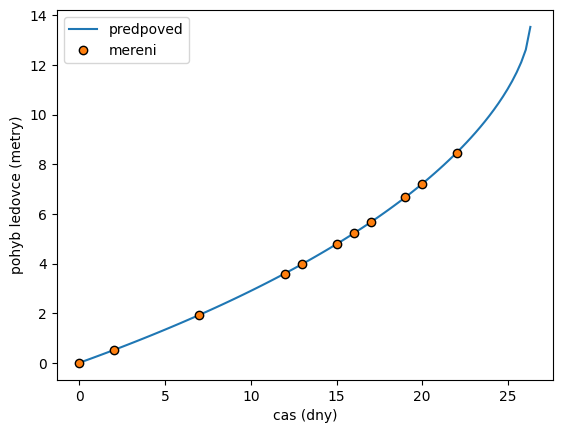

In [ ]:
def PohybLedovce(t,s0,v0,a0,t_infty,n):
  return

t = np.array([0,2.,7.,12.,13.,15.,16.,17.,19.,20.,22.])
s = np.array([0,0.529,1.936,3.598,3.977,4.802,5.219,5.667,6.669,7.208,8.464])

... = curve_fit(...)
PredpovezenyCasUtrzeni = ...
t_mesh = np.linspace(t[0],PredpovezenyCasUtrzeni,100)
plt.plot(... ,label="predpoved")
plt.plot(... ,'o',markeredgecolor='k',label="mereni")
plt.xlabel("cas (dny)"); plt.ylabel("pohyb ledovce (metry)"); plt.legend(); plt.show()

## Část B - Ortogonální polynomy

---
- [poznámky z přednášky - ortogonální polynomy](https://www.karlin.mff.cuni.cz/~kucera/ZNM/4%20-%20Ortogonalni%20polynomy.pdf)
- další materiály:
  - částečně dostupná (a hodně pokročilá) kniha [Trefethen: Approximation Theory and Approximation Practice](https://www.chebfun.org/ATAP/atap-first6chapters.pdf) (Kapitoly 2 a 3)
  
- ***Primární úlohy*** : B1

- ***Úlohy k bonusové části zkoušky*** : B1

- základní ***Learning outcomes*** (cviko, nikoliv přednáška)
  - Umím definovat ortogonalitu polynomů.
  - Umím transformovat ortogonální polynomy na intervalu $(a,b)$ na ortogonální polynomy na intervalu $(c,d)$.
  - Umím charakterizovat Chebyshevovy polynomy pomocí min-max vlastnosti.
---

### Intro

Velkou část první půlky semestru jsme strávili příklady z numerické lineární algebry, které mimo jiné ilustrovali důležitost ***ortogonálních/ortonormálních transformací*** - pro numerické výpočty se ukázali naprosto klíčové.

Jedna přirozená navazující otázka je:
> "Ano, v lingebře to je vcelku přímočaré, ale co nám to říká o tom, jak počítat s funkcemi/integrály?"

Jedna z možných odpovědí je následující (a má dvě části):

- Musíme pracovat s funkcemi v kontextu vektorových prostorů (takové příklady jste již na lingebře viděli a na teorii míry přibydou další).

- Pro řešení úloh s funkcemi je pak nutné/vhodné používat podobné algoritmy jako v lineární algebře a vyvarovat se výpočtům se špatně podmíněnými transformacemi a/nebo ve špatně podmíněných bázích.


Tuto ideu hloubějí rozpracovává [NMMA331: Úvod do funkcionální analýzy](https://is.cuni.cz/studium/predmety/index.php?do=predmet&kod=NMMA331) nebo [NMMA204: Matematická analýza 4](https://is.cuni.cz/studium/predmety/index.php?do=predmet&kod=NMMA204), které vás čekají v dalším průběhu studia a tvoří naprosto fundamentální základ/rámec pro mnoho, ne-li většinu moderních výpočtů.

V tomhle kurzu uvidíme v následujících dvou týdnech, že jeden takový vhodný postup pro manipulaci s funkcemi je tzv. ***Lagrangeova interpolace v Chebyshevových/Legendrových bodech***. Takže na tomhle cviku se podíváme co jsou ty Chebyshevovy a Legendrovy body zač.

Začneme tím, že si vezmeme vektorový prostor polynomiálních funkcí, tj.

$$
\mathcal{P}_n = \{ \, p(x) : [a,b] \rightarrow \mathbb{R} \, |\; p \; \mathrm{je\, polynom} \; \; \& \; \; \mathrm{deg}(p)\leq n \,\}
\quad \mathrm{a}\quad
\mathcal{P} = \{ \, p(x) : [a,b] \rightarrow \mathbb{R} \, |\; p \; \mathrm{je\, polynom} \,\}
$$

a opatříme ho skalárním součinem $(\cdot, \cdot )_{w}$ definovaným jako

$$ (p,q)_{w} := \int_a^b p(x)q(x) \cdot w(x) \mathrm{d}x, $$

kde $w(x) : [a,b] \rightarrow \mathbb{R}$ je nezáporná spojitá funkce. Vůči tomuto skalárnímu součinu pak zjevně můžeme konstruovat ortogonální/ortonormální bazi prostoru $\mathcal{P}_n$ pro libovolné $n$ a tedy i prostoru $\mathcal{P}$.

V praxi je důležitých několik konkrétních set-upů - my si z nich zmíníme "dva" konkrétní:

- [Chebyshevovy polynomy $T_n(x)$](https://en.wikipedia.org/wiki/Chebyshev_polynomials#) odpovídající $w(x):= 1/\sqrt{1-x^2}$ & $[a,b] = [-1,1]$,
  - existují ve skutečnosti dva typy Chebyshevových polynomů - Chebyshevovy polynomy 1. druhu (ustálené znaření $T_n(x)$, definice výše) a Chebyshevovy polynomy 2. druhu (ustálené znaření $U_n(x)$, odpovíddají $w(x):= \sqrt{1-x^2}$).
  - Chebyshevovy polynomy 1. druhu $T_n(x)$ můžeme charakterizovat také pomocí
  $$\mathrm{arg}\min\limits_{q_n \in \mathcal{Q}_n} \, \max\limits_{x\in [-1,1]} \, |q_n(x)| = T_n(x),
  \quad \& \quad
  \min\limits_{q_n \in \mathcal{Q}_n} \, \max\limits_{x\in [-1,1]} \, |q_n(x)| = \max\limits_{x\in [-1,1]} \, |T_n(x)|  = \frac{1}{2^{n-1}}
  $$
  kde $\mathcal{Q}_n$ je set všech ***monických*** polynomů stupně nejvýše $n$.

- [Legendrovy polynomy $P_n(x)$](https://en.wikipedia.org/wiki/Legendre_polynomials) odpovídající $w(x):= 1$ & $[a,b] = [-1,1]$.

- Chebyshevovy/Legendrovy polynomy na $[a,b]$ konstruujeme následovně
  - vezmeme si lineární transformaci $t(x) = \alpha x + \beta$, která zobrazí $[a,b]$ na $[-1,1]$ a zároveň zobrazí krajní body na krajní body, tedy
  \begin{equation}
  t \, : \, [a,b] \rightarrow [-1,1] \quad \mathrm{a} \quad t(a)=-1 \; \& \; t(b)=1
  \end{equation}
  a označíme si novou porměnnou jako $\xi := t(x) \in [-1,1]$.
  - $n$-tý Chebyshevův polynom na $[a,b]$ označíme jako $\tilde{T}_n(x)$ a definujeme ho jako
  $$ \tilde{T}_n := T_n \circ t \quad \mathrm{tj.}\quad \tilde{T}_n(x) := T_n(t(x)), $$
  kde $T_n(\xi)$ je $n$-tý Chebyshevův polynom definovaný výše.

  - $n$-tý Legendrův polynom na $[a,b]$ označíme jako $\tilde{P}_n(x)$ a definujeme ho jako
  $$ \tilde{P}_n := P_n \circ t \quad \mathrm{tj.}\quad \tilde{P}_n(x) := P_n(t(x)), $$
  kde $P_n(\xi)$ je $n$-tý Legendrův polynom definovaný výše.


### Úloha B1

Na přednášce jsme si zadefinovali Chebyshevovy polynomy 1. durhu jako

$$ T_n(x) := \cos \left( n \arccos (x) \right) .$$

---
**Tužka a papír** :

- Ukažte, že funkce $T_n$ je opravdu polynomem stupně právě $n$.

  <details>
  <summary>Chci <font color="red"><b>hint 1</b></font></summary>
  
  Odvoďte rekurentní vztah pro výpočet Chebyshevova polynomu $T_{n+1}(x)$ na základě $T_{n}(x)$ a $T_{n-1}(x)$.
  
  </details>

  <details>
  <summary>Chci <font color="red"><b>hint 2</b></font></summary>
  
  Zopakujte si [součtové vzorce](https://en.wikipedia.org/wiki/Trigonometric_functions#Basic_identities) pro $\cos()$.
  
  </details>

- Ukažte, že kořeny $T_n$ jsou dány jako
  $$ x_k=\cos\left(\dfrac{\left( 2k-1\right)\pi}{2n}\right), \quad k=1,\ldots,n.$$
  a extrémy (minima a maxima) jsou dány jako
  $$ x_k=\cos\left(\dfrac{k\pi}{n}\right), \quad k=0,\ldots,n. $$

- Vezmeme si obecný konečný interval $[a,b]$.
  - Najděte afiní transformaci $t \, : \, [a,b] \rightarrow [-1,1]$, která zobrazí krajní body na krajní body, tj. $t(a)=-1$ \& $t(b)=1$.
  - Ukažte, že funkce $\tilde{T}_n,\tilde{P}_n$ definované výše jsou polynomy.
  - Ukažte, že Legendrovy polynomy na $[a,b]$ jsou ortogonální.
  - Ukažte, vůči které funkci $w(x)$ jsou Chebyshevovy polynomy na $[a,b]$ ortogonální.
  

  <details>
  <summary>Chci <font color="red"><b>hint 1</b></font></summary>
  
  Vše lze převést na manipulaci s LEgendrovy/chebyshevovy polynomy na $[-1,1]$, kde máme teorii z přednášky shrnutou výše, o kterou se můžeme opřít.
  
  </details>
---

### ZÚ - zachovávání min-max vlastností

---
**Tužka a papír**: Ukažte, že Chebyshevovy polynomy na $[a,b]$ lze charakterizovat analogicky jako výše - konkrétně, že platí

$$
\mathrm{arg}\min\limits_{q_n \in \mathcal{Q}_n} \, \max\limits_{x\in [a,b]} \, |q_n(x)| = \tilde{T}_n(x)
\quad \& \quad
\min\limits_{q_n \in \mathcal{Q}_n} \, \max\limits_{x\in [a,b]} \, |q_n(x)| = \max\limits_{x\in [a,b]} \, |\tilde{T}_n(x)| = 2 \left( \frac{b-a}{4} \right)^{n},$$

pro libovolné $n\in \mathbb{N}$ <details>
<summary>Chci <font color="red"><b>hint 1</b></font></summary>
Vše lze převést na manipulaci s Legendrovy/chebyshevovy polynomy na $[-1,1]$, kde máme teorii z přednášky shrnutou výše, o kterou se můžeme opřít. Jak vypadá inverzní tranformace $t^{-1} \, : \, [-1,1] \rightarrow [a,b]$?

</details>
<details>
<summary>Chci <font color="red"><b>hint 2</b></font></summary>
Monické polynomy jsou obecně tvaru $x^n + \sum\limits_{i=0}^{n-1} \gamma_i x^i$. Pokud máme polynom tvaru $(\alpha x + \beta)^n + \sum\limits_{i=0}^{n-1} \gamma_i (\alpha x + \beta)^i$, jaký je koeficient u jeho vedoucího členu, tj. u $x^n$? Jak můžeme přepsat tento polynom na $C \cdot q_n(x)$ pro nějaký monický polynom $q_n$?

</details>

---

### Ilustrace

Monické polynomy stupně $n$ s kořeny $x_1,\dotsc ,x_n \in \mathbb{R}$ můžeme zapsat jako
$$q_n(x) = (x-x_1)\cdot \dotsc \cdot (x-x_n). \qquad (\star)$$
Ortogonální polynomy (jako třeba Legendrovy nebo Chebyshevovy) mají všechny kořeny reálné, takže je opravdu můžeme zapsat v součinovém tvaru výše. Níže jsou vykreslené 3 typy monických polynomů tvaru $(\star)$:
  - $x_1,\dotsc ,x_n$ bereme jako kořeny $n$-tého Chebyshevova polynomu na $[-1,1]$ (a tedy $q_n(x) = (x-x_1)\cdot \dotsc \cdot (x-x_n) =T_n(x)$),
  - $x_1,\dotsc ,x_n$ bereme jako kořeny $n$-tého Legendrova polynomu na $[-1,1]$ (a tedy $q_n(x) = (x-x_1)\cdot \dotsc \cdot (x-x_n) =P_n(x)$),
  - $x_1,\dotsc ,x_n$ bereme jako ekvidisitatní body na $[-1,1]$ (analogické Wilkinsonovu polynomu),


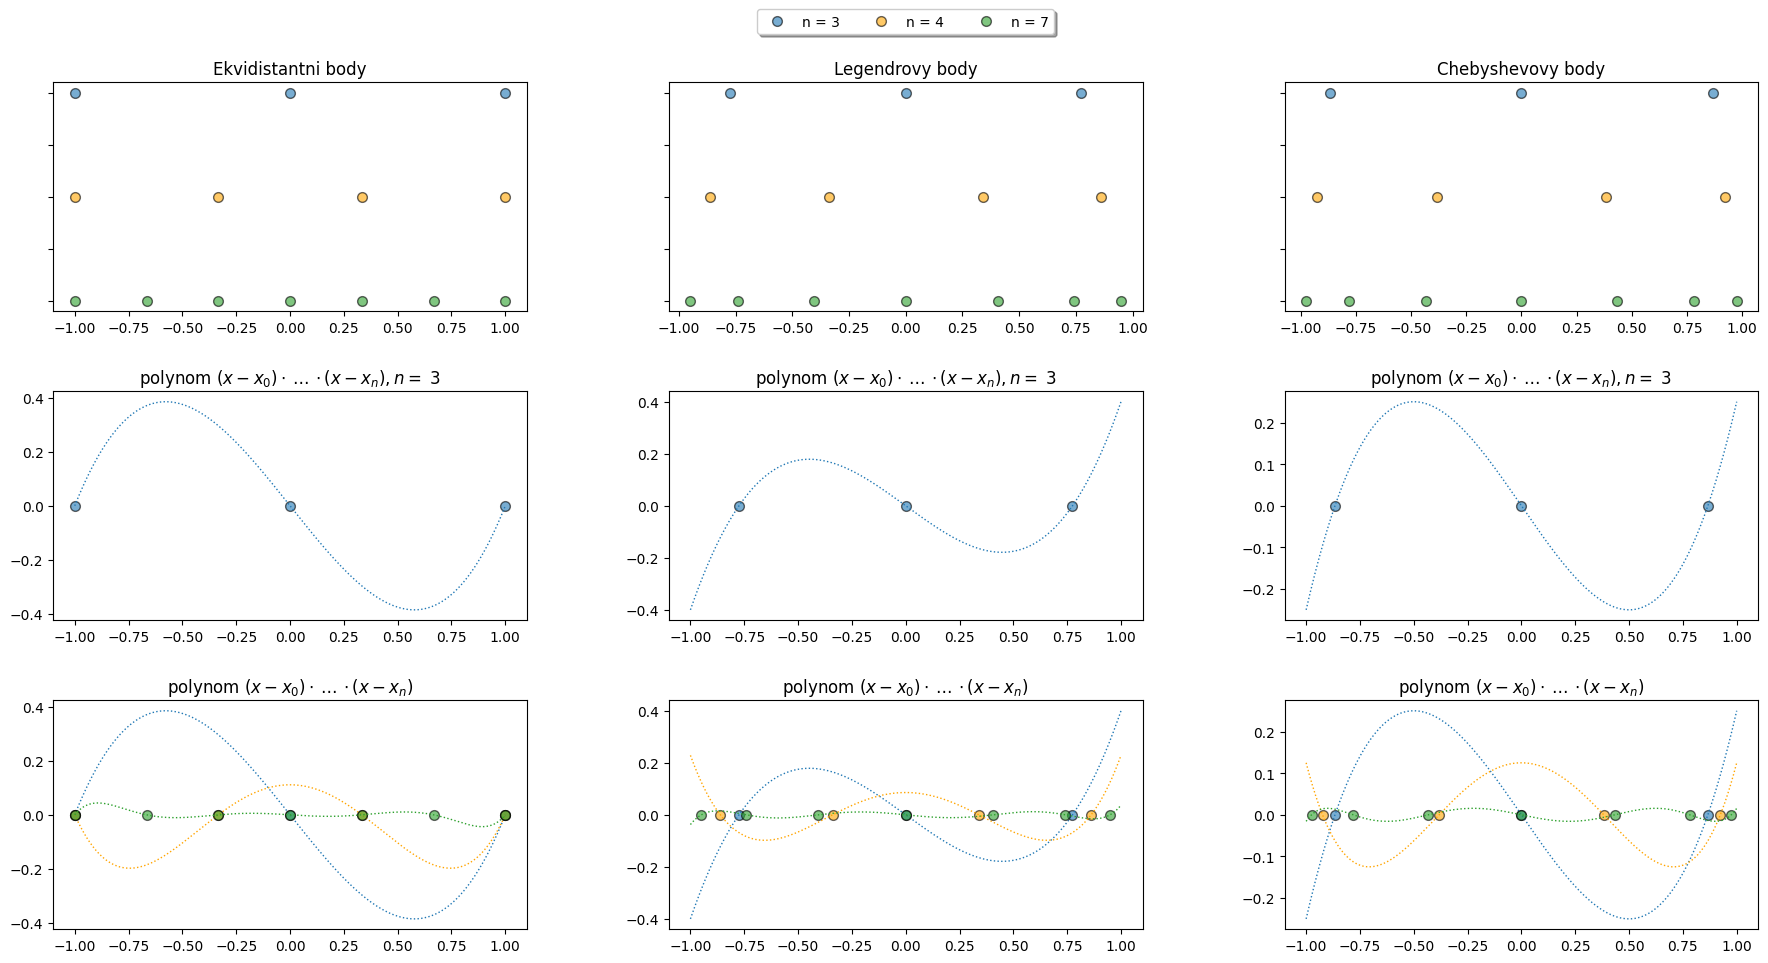

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_chebyt, roots_legendre
from numpy.polynomial.polynomial import polyvalfromroots


a = -1; b = 1; n_totry = [3,4,7];
MyColors = ["tab:blue","orange","tab:green"]; x_eval = np.linspace(a,b,1000);
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]] = plt.subplots(nrows=3, ncols=3, figsize=(22, 11), gridspec_kw={'hspace': 0.35, 'wspace': 0.3})


for ind in range(0,len(n_totry)):

  n = n_totry[ind];
  x_equi = np.linspace(a,b,n); x_cheb = roots_chebyt(n)[0]; x_leg = roots_legendre(n)[0];

  ### equi
  ax1.set_title("Ekvidistantni body")
  ax1.plot(x_equi, np.ones(len(x_equi))*(-ind), label="n = {}".format(n), c = MyColors[ind], lw=0, marker ="o", alpha=.6, ms=7, markeredgecolor="k"); ax3.set_yticklabels([])

  if ind == 0:
    ax4.set_title(r"polynom $(x-x_0)\cdot \dots \cdot (x-x_n), n =$ {}".format(n_totry[ind]))
    ax4.plot(x_equi, np.zeros(len(x_equi)), lw=0, marker ="o", c = MyColors[ind], alpha=.6, ms=7, markeredgecolor="k");
    ax4.plot(x_eval, polyvalfromroots(x_eval, x_equi), ':', c = MyColors[ind], label="n = {}".format(n), lw=1)

  ax7.set_title(r"polynom $(x-x_0)\cdot \dots \cdot (x-x_n)$")
  ax7.plot(x_equi, np.zeros(len(x_equi)), lw=0, marker ="o", c = MyColors[ind], alpha=.6, ms=7, markeredgecolor="k");
  ax7.plot(x_eval, polyvalfromroots(x_eval, x_equi), ':', c = MyColors[ind], label="n = {}".format(n), lw=1)

  ### leg
  ax2.set_title("Legendrovy body")
  ax2.plot(x_leg, np.ones(len(x_leg))*(-ind), label="n = {}".format(n), lw=0, c = MyColors[ind], marker ="o", alpha=.6, ms=7, markeredgecolor="k"); ax2.set_yticklabels([])
  ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=5);

  if ind == 0:
    ax5.set_title(r"polynom $(x-x_0)\cdot \dots \cdot (x-x_n), n =$ {}".format(n_totry[ind]))
    ax5.plot(x_leg, np.zeros(len(x_leg)), lw=0, marker ="o", c = MyColors[ind], alpha=.6, ms=7, markeredgecolor="k");
    ax5.plot(x_eval, polyvalfromroots(x_eval, x_leg), ':', c = MyColors[ind], label="n = {}".format(n), lw=1)

  ax8.set_title(r"polynom $(x-x_0)\cdot \dots \cdot (x-x_n)$")
  ax8.plot(x_leg, np.zeros(len(x_leg)), lw=0, marker ="o", c = MyColors[ind], alpha=.6, ms=7, markeredgecolor="k");
  ax8.plot(x_eval, polyvalfromroots(x_eval, x_leg), ':', c = MyColors[ind], label="n = {}".format(n), lw=1)
  #ax8.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5);


  ### cheb
  ax3.set_title("Chebyshevovy body")
  ax3.plot(x_cheb, np.ones(len(x_cheb))*(-ind), label="n = {}".format(n), c = MyColors[ind], lw=0, marker ="o", alpha=.6, ms=7, markeredgecolor="k"); ax1.set_yticklabels([])

  if ind == 0:
    ax6.set_title(r"polynom $(x-x_0)\cdot \dots \cdot (x-x_n), n =$ {}".format(n_totry[ind]))
    ax6.plot(x_cheb, np.zeros(len(x_cheb)), lw=0, c = MyColors[ind], marker ="o", alpha=.6, ms=7, markeredgecolor="k");
    ax6.plot(x_eval, polyvalfromroots(x_eval, x_cheb), ':', c = MyColors[ind], label="n = {}".format(n), lw=1)

  ax9.set_title(r"polynom $(x-x_0)\cdot \dots \cdot (x-x_n)$")
  ax9.plot(x_cheb, np.zeros(len(x_cheb)), lw=0, c = MyColors[ind], marker ="o", alpha=.6, ms=7, markeredgecolor="k");
  ax9.plot(x_eval, polyvalfromroots(x_eval, x_cheb), ':', c = MyColors[ind], label="n = {}".format(n), lw=1)



plt.show()

## [Kvíz](https://forms.gle/G4DXJwsAr47QXPyn6)